In [ ]:
import pandas as pd
import numpy as np

import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
warnings.simplefilter("ignore")
from keras.models import Model
from keras.layers import LeakyReLU
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.layers.merge import concatenate
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/data/fer2013.csv')

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
data.shape

(35887, 3)

In [ ]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
data = data.sample(frac=1)


In [ ]:
labels = to_categorical(data[['emotion']], num_classes=7)


In [ ]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

In [ ]:
pixels = train_pixels.reshape((35887*2304,1))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

In [ ]:
pixels = train_pixels.reshape((35887, 48, 48,1))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


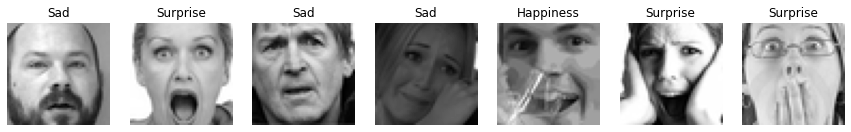

In [ ]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img,cmap='gray')
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

In [ ]:
datagen.fit(X_train)
valgen.fit(X_val)

In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

In [ ]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
      
  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten()) 
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
      
  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model


In [ ]:
model = cnn_model()

In [ ]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
454/455 [============================>.] - ETA: 0s - loss: 14.0793 - accuracy: 0.1874
Epoch 1: val_accuracy improved from -inf to 0.25325, saving model to best_model.h5
455/455 [==============================] - 24s 45ms/step - loss: 14.0773 - accuracy: 0.1874 - val_loss: 12.7926 - val_accuracy: 0.2533
Epoch 2/30
454/455 [============================>.] - ETA: 0s - loss: 12.1717 - accuracy: 0.2137
Epoch 2: val_accuracy improved from 0.25325 to 0.25851, saving model to best_model.h5
455/455 [==============================] - 18s 40ms/step - loss: 12.1695 - accuracy: 0.2136 - val_loss: 10.9578 - val_accuracy: 0.2585
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 10.2016 - accuracy: 0.2310
Epoch 3: val_accuracy improved from 0.25851 to 0.26254, saving model to best_model.h5
455/455 [==============================] - 18s 40ms/step - loss: 10.2016 - accuracy: 0.2310 - val_loss: 9.0617 - val_accuracy: 0.2625
Epoch 4/30
454/455 [============================>.

In [ ]:
model.save('cnn_model_30epoch_Adam.h5')

In [ ]:
model = tf.keras.models.load_model('cnn_model_30epoch_Adam.h5')


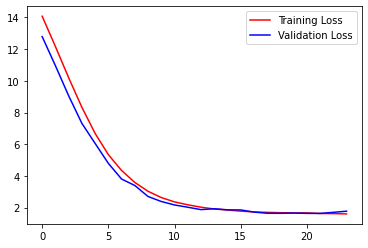

In [ ]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

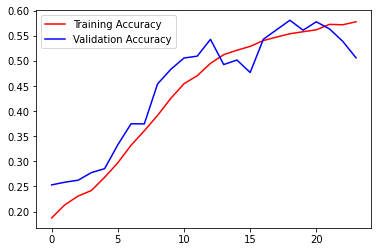

In [ ]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [ ]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 2s 9ms/step - loss: 1.5931 - accuracy: 0.5770
Test Acc: 0.57704097032547


In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )


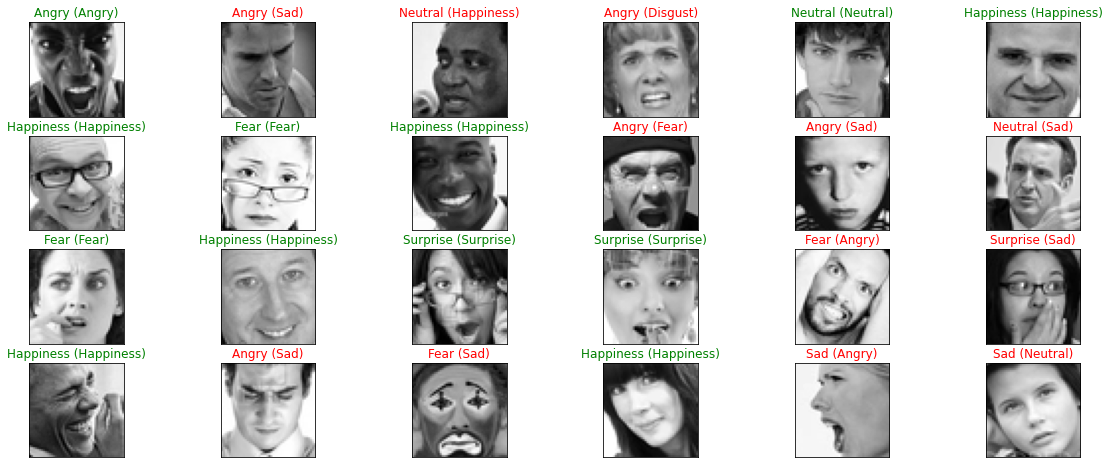

In [ ]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]),cmap='gray')
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.461     0.449     0.455       474
           1      0.571     0.078     0.138        51
           2      0.468     0.211     0.291       511
           3      0.804     0.836     0.820       911
           4      0.445     0.450     0.448       635
           5      0.550     0.806     0.654       376
           6      0.528     0.626     0.573       631

    accuracy                          0.577      3589
   macro avg      0.547     0.494     0.483      3589
weighted avg      0.569     0.577     0.560      3589



In [ ]:
model2 = cnn_model()


In [ ]:
model2.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
history2= model2.fit(train_generator,
                    epochs=50,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/50
454/455 [============================>.] - ETA: 0s - loss: 14.0849 - accuracy: 0.1825
Epoch 1: val_accuracy improved from -inf to 0.25387, saving model to best_model.h5
455/455 [==============================] - 20s 41ms/step - loss: 14.0830 - accuracy: 0.1826 - val_loss: 12.8045 - val_accuracy: 0.2539
Epoch 2/50
454/455 [============================>.] - ETA: 0s - loss: 12.1559 - accuracy: 0.2122
Epoch 2: val_accuracy improved from 0.25387 to 0.27152, saving model to best_model.h5
455/455 [==============================] - 20s 44ms/step - loss: 12.1539 - accuracy: 0.2121 - val_loss: 10.9114 - val_accuracy: 0.2715
Epoch 3/50
455/455 [==============================] - ETA: 0s - loss: 10.1778 - accuracy: 0.2302
Epoch 3: val_accuracy did not improve from 0.27152
455/455 [==============================] - 18s 40ms/step - loss: 10.1778 - accuracy: 0.2302 - val_loss: 9.0687 - val_accuracy: 0.2492
Epoch 4/50
454/455 [============================>.] - ETA: 0s - loss: 8.3134 - accura

In [ ]:
loss2 = model2.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 9ms/step - loss: 1.4895 - accuracy: 0.6116
Test Acc: 0.57704097032547


In [ ]:
preds2 = model2.predict(X_test)
y_pred2 = np.argmax(preds2 , axis = 1 )

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred2,digits=3))

              precision    recall  f1-score   support

           0      0.455     0.597     0.516       474
           1      0.714     0.098     0.172        51
           2      0.556     0.176     0.267       511
           3      0.806     0.883     0.843       911
           4      0.514     0.490     0.502       635
           5      0.704     0.734     0.719       376
           6      0.530     0.675     0.594       631

    accuracy                          0.612      3589
   macro avg      0.611     0.522     0.516      3589
weighted avg      0.612     0.612     0.591      3589



In [ ]:
model2.save('epoch50.h5')


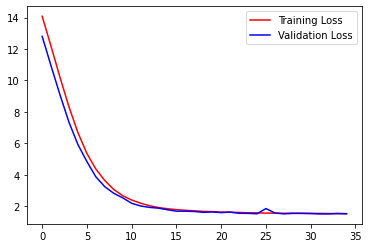

In [ ]:
plt.plot(history2.history["loss"],'r', label="Training Loss")
plt.plot(history2.history["val_loss"],'b', label="Validation Loss")
plt.legend()

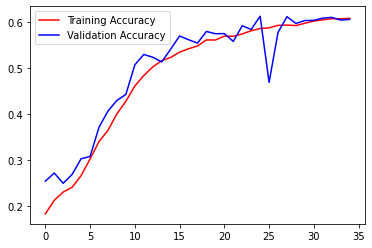

In [ ]:
plt.plot(history2.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history2.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

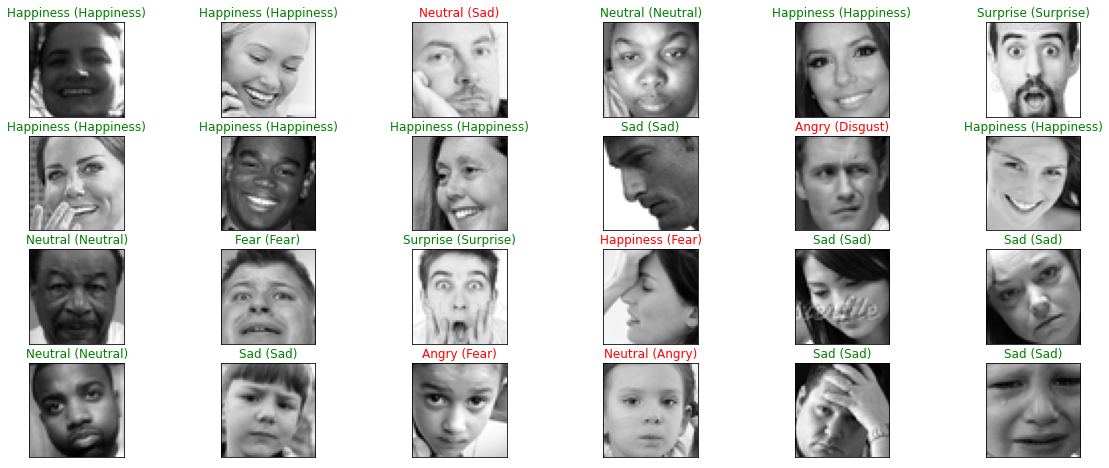

In [ ]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]),cmap='gray')
    predict_index = label_dict[(y_pred2[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('user uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving IMG_5010.JPG to IMG_5010.JPG
user uploaded file "IMG_5010.JPG" with length 612079 bytes


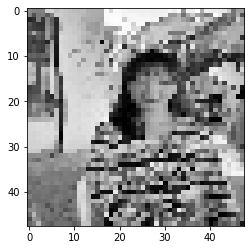

[0.0892603  0.00140701 0.13051556 0.32529572 0.30321208 0.07724466
 0.07306466]


In [ ]:
img = image.load_img('/content/IMG_5010.JPG', grayscale=True, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255
custom = model2.predict(x)

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()
print(custom[0])

In [ ]:
custom = custom[0]
emotion = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
#Find the maximum probablity of a image and select that class
lar = 0
for i, ele in enumerate(custom):
    if ele > lar:
        msg = emotion[i]
        lar = ele 
    else:
         pass
print(msg)

happy


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
    print('user uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving upset.jpg to upset.jpg
user uploaded file "upset.jpg" with length 206813 bytes


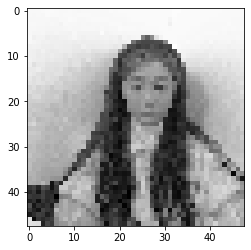

[0.08947867 0.00145542 0.12922153 0.33381507 0.29162106 0.07907815
 0.07533011]


In [ ]:
img2 = image.load_img('/content/upset.jpg', grayscale=True, target_size=(48, 48))
x = image.img_to_array(img2)
x = np.expand_dims(x, axis=0)
x /= 255
custom = model2.predict(x)

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()
print(custom[0])

In [ ]:
custom = custom[0]
emotion = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
#Find the maximum probablity of a image and select that class
lar = 0
for i, ele in enumerate(custom):
    if ele > lar:
        msg = emotion[i]
        lar = ele 
    else:
         pass
print(msg)

happy


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
    print('user uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving funny.jpg to funny.jpg
user uploaded file "funny.jpg" with length 629641 bytes


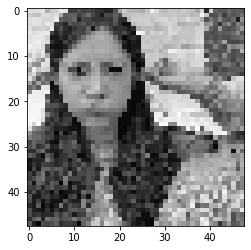

[0.08922452 0.00142896 0.12968309 0.32778695 0.29938436 0.07800293
 0.07448924]


In [ ]:
img3 = image.load_img('/content/funny.jpg', grayscale=True, target_size=(48, 48))
x = image.img_to_array(img3)
x = np.expand_dims(x, axis=0)
x /= 255
custom = model2.predict(x)

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()
print(custom[0])

In [ ]:
custom = custom[0]
emotion = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
#Find the maximum probablity of a image and select that class
lar = 0
for i, ele in enumerate(custom):
    if ele > lar:
        msg = emotion[i]
        lar = ele 
    else:
         pass
print(msg)

In [ ]:
import io
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

def predict_emotion(path):
    img = image.load_img(path, grayscale=True, target_size=(48, 48))
    show_img=image.load_img(path, grayscale=False, target_size=(200, 200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255

    custom = model.predict(x)
    emotion_analysis(custom[0])

    x = np.array(x, 'float32')
    x = x.reshape([48, 48]);

    plt.gray()
    plt.imshow(show_img)
    plt.show()

    m=0.000000000000000000001
    a=custom[0]
    for i in range(0,len(a)):
        if a[i]>m:
            m=a[i]
            ind=i
        
    print('Expression Prediction:',objects[ind])

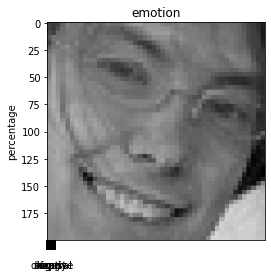

Expression Prediction: sad


In [ ]:
predict_emotion('/content/drive/MyDrive/data/FER2013/test/happy/PrivateTest_14365414.jpg')